<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/results/AMES_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu121
cuda:  True


In [ ]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet
! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet

## Code

In [1]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [2]:
from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *
import yaml
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
from scripts.CONSTANT import *
from scripts.yaml_utils import *
from scripts.TRAIN import *
print('VOCAB TYPE:', VOCAB_TYPE)

VOCAB TYPE: smiles


In [3]:
def process_ensemble_v1(tst, folder_name='T3/uw',
                        model_dict={
                            'MLP': 1,
                            'AttentiveFP':2,
                            'GIN':1,
                            'RNN':1
                        }):
    task_names = tst.columns.tolist()
    # print('col names', col_names)
    task_names.remove('Drug')
    print('task names',task_names)
    df_list = []
    for i in range(len(task_names)):
        # print(i, M5[i])

        # append true labels into df_list
        temp_df = pd.DataFrame()
        temp_df['Drug'] = tst['Drug'].tolist()
        temp_df[task_names[i]] = tst[task_names[i]].tolist()
        df_list.append(temp_df)

    for model_type, model_num in model_dict.items():
        file_name = f'{folder_name}/{model_type}_MT_{model_num}.yml'
        with open(file_name, 'r') as f: yml_data = yaml.safe_load(f)
        models = PRED(**yml_data['config'])
        models.load_status(yml_data)

        df = models.predict(tst['Drug'].tolist(), return_probs=True)
        for j in range(len(task_names)):
            df_list[j][model_type] = df[task_names[j]].tolist()
    return df_list

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

class ensemble_dataset(Dataset):
    def __init__(self, df, task_name, mask=MASK,
                 header=['MLP', 'AttentiveFP', 'GIN', 'RNN']):
        super(ensemble_dataset, self).__init__()

        self.df = df.copy().fillna(mask)
        self.len = len(df)
        self.fp = self.df[header]
        self.props = self.df[[task_name]]
    def __len__(self): return self.len
    def __getitem__(self, idx):
        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return fp, label


In [17]:
names = names_T3
folder_name  = 'T3/uw'
model_dict={'MLP': 1,
            'AttentiveFP':2,
            'GIN':0,
            'RNN':0
            }
repeat_time = 3
retrain = False

trn, val, tst = collect_data(names)

trn_list = process_ensemble_v1(trn, folder_name, model_dict)
val_list = process_ensemble_v1(val, folder_name, model_dict)
tst_list = process_ensemble_v1(tst, folder_name, model_dict)


Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


collect data for:  ['hERG_Karim', 'AMES', 'LD50_Zhu']
task names ['hERG_Karim', 'AMES', 'LD50_Zhu']
Model type:  MLP | Model parameters:  32419
finish load data status 

load pretrained model from  T3/uw/MLP_MT_1.pt
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED


Predicting...: 100%|██████████| 296/296 [00:03<00:00, 92.82it/s]


Model type:  AttentiveFP | Model parameters:  3824109
finish load data status 

load pretrained model from  T3/uw/AttentiveFP_MT_2.pt
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 4468 tasks      | elapsed:    3.9s
[Parallel(n_jobs=6)]: Done 12468 tasks      | elapsed:   10.6s
[Parallel(n_jobs=6)]: Done 18928 out of 18928 | elapsed:   15.6s finished
Predicting...: 100%|██████████| 296/296 [00:05<00:00, 51.48it/s]


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 63.2MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978767
finish load data status 

load pretrained model from  T3/uw/GIN_MT_0.pt
--> preparing data loader for model type  GIN


Predicting...: 100%|██████████| 296/296 [00:43<00:00,  6.79it/s]


Model type:  RNN | Model parameters:  2980999
finish load data status 

load pretrained model from  T3/uw/RNN_MT_0.pt
--> preparing data loader for model type  RNN


Predicting...: 100%|██████████| 296/296 [00:06<00:00, 42.98it/s]


task names ['hERG_Karim', 'AMES', 'LD50_Zhu']
Model type:  MLP | Model parameters:  32419
finish load data status 

load pretrained model from  T3/uw/MLP_MT_1.pt
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED


Predicting...: 100%|██████████| 44/44 [00:00<00:00, 93.31it/s]
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Model type:  AttentiveFP | Model parameters:  3824109
finish load data status 

load pretrained model from  T3/uw/AttentiveFP_MT_2.pt
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.3s
[Parallel(n_jobs=6)]: Done 2732 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done 2791 out of 2791 | elapsed:    2.6s finished
Predicting...: 100%|██████████| 44/44 [00:00<00:00, 52.95it/s]


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 63.9MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978767
finish load data status 

load pretrained model from  T3/uw/GIN_MT_0.pt
--> preparing data loader for model type  GIN


Predicting...: 100%|██████████| 44/44 [00:06<00:00,  6.74it/s]


Model type:  RNN | Model parameters:  2980999
finish load data status 

load pretrained model from  T3/uw/RNN_MT_0.pt
--> preparing data loader for model type  RNN


Predicting...: 100%|██████████| 44/44 [00:01<00:00, 41.29it/s]


task names ['hERG_Karim', 'AMES', 'LD50_Zhu']
Model type:  MLP | Model parameters:  32419
finish load data status 

load pretrained model from  T3/uw/MLP_MT_1.pt
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED


Predicting...: 100%|██████████| 87/87 [00:00<00:00, 92.89it/s]
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Model type:  AttentiveFP | Model parameters:  3824109
finish load data status 

load pretrained model from  T3/uw/AttentiveFP_MT_2.pt
--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 4468 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 5551 out of 5551 | elapsed:    4.5s finished
Predicting...: 100%|██████████| 87/87 [00:01<00:00, 54.41it/s]


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 70.8MB/s]

Pretrained model loaded


Model type:  GIN | Model parameters:  1978767
finish load data status 

load pretrained model from  T3/uw/GIN_MT_0.pt
--> preparing data loader for model type  GIN


Predicting...: 100%|██████████| 87/87 [00:12<00:00,  7.19it/s]


Model type:  RNN | Model parameters:  2980999
finish load data status 

load pretrained model from  T3/uw/RNN_MT_0.pt
--> preparing data loader for model type  RNN


Predicting...: 100%|██████████| 87/87 [00:02<00:00, 41.68it/s]


## Evaluate results on AMES

In [82]:
task_name = 'AMES'
model_type = 'GIN'
folder_name = f'ST/{task_name}'
# i = 1
for i in range(3):
    file_name = f'{folder_name}/{model_type}_ST_{i}.yml'
    p = yml_report(file_name)
    eval_perf_list([p], task_name)

******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.815   &0.890   &0.902   
******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.809   &0.886   &0.897   
******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.809   &0.887   &0.902   


In [83]:
for i in range(3):
    file_name = f'T3/uw_no/{model_type}_MT_{i}.yml'
    p = yml_report(file_name)
    eval_perf_list([p], task_name)

******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.834   &0.898   &0.911   
******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.819   &0.893   &0.907   
******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.830   &0.893   &0.907   


In [84]:
for i in range(3):
    file_name = f'T3/uw/{model_type}_MT_{i}.yml'
    p = yml_report(file_name)
    eval_perf_list([p], task_name)

******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.815   &0.892   &0.907   
******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.832   &0.900   &0.910   
******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.828   &0.896   &0.908   


In [85]:
for i in range(3):
    file_name = f'T3/uw/MUE_{task_name}_{i}.yml'
    p = yml_report(file_name)
    eval_perf_list([p], task_name)

******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.828   &0.904   &0.922   
******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.824   &0.907   &0.922   
******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.832   &0.907   &0.923   


### Single task on hERG, ST-GIN

Found local copy...
Loading...
Done!


collect data for:  ['AMES']
--> preparing data loader for model type  GIN


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 71.2MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978733
finish load data status 

load pretrained model from  ST/AMES/GIN_ST_2.pt
[Test] Loss: 0.422
*************** AMES ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.809  &0.806  &0.817  &0.840  &0.772  &0.828 &0.887 &0.614 &0.902


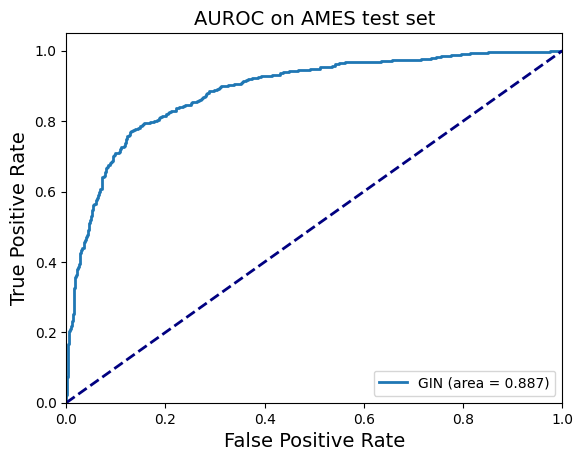

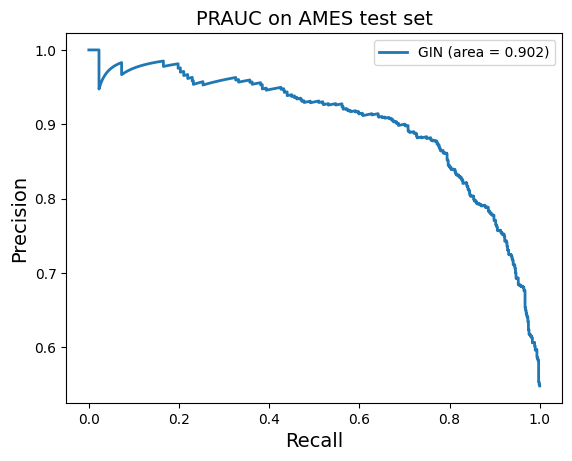

In [86]:
task_name = 'AMES'
model_type = 'GIN'
folder_name = f'ST/{task_name}'
i = 2

file_name = f'{folder_name}/{model_type}_ST_{i}.yml'
p_ST = yml_report(file_name, recalculate=True, return_all=True)

## Multitask on AMES, no uncertainty weight, MT-GIN



Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


collect data for:  ['LD50_Zhu', 'hERG_Karim', 'AMES']

START scaling train valid test data set: 
---> scale LD50_Zhu | min -0.343 | max 10.207
Finished scaling process | dict_scale: {'LD50_Zhu': [-0.3429999999999999, 10.207]} 

discrepancy:config scale_dict and real scale_dict
config[scale_dict]: {'AMES': [0.0, 1.0], 'LD50_Zhu': [-0.3429999999999999, 10.207], 'hERG_Karim': [0.0, 1.0]}
scale_dict directly after scale: {'LD50_Zhu': [-0.3429999999999999, 10.207]}
--> preparing data loader for model type  GIN


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 74.7MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978767
finish load data status 

load pretrained model from  T3/uw_no/GIN_MT_2.pt
[Test] Loss: 0.161
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.617  &0.654  &0.808  &0.269


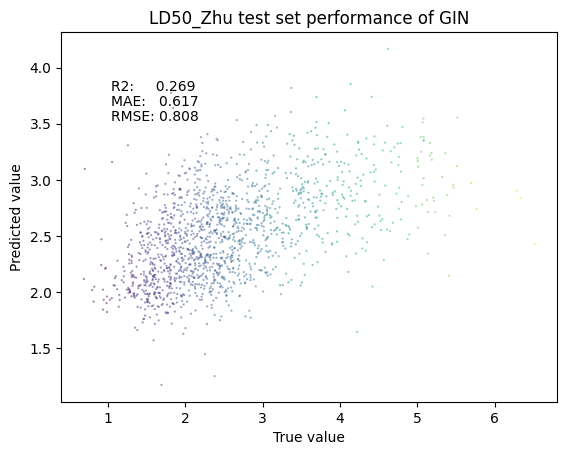


*************** hERG_Karim ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.800  &0.800  &0.807  &0.789  &0.811  &0.797 &0.880 &0.600 &0.884


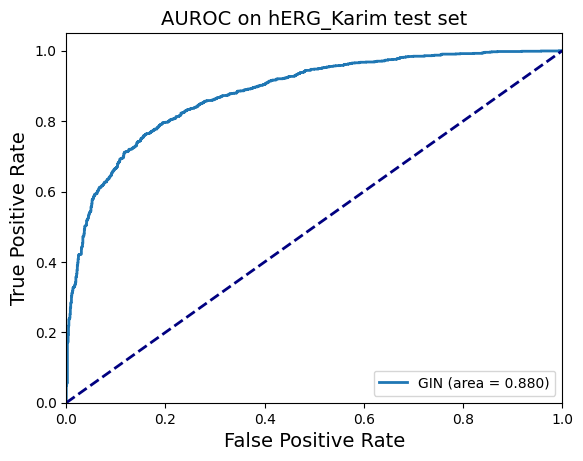

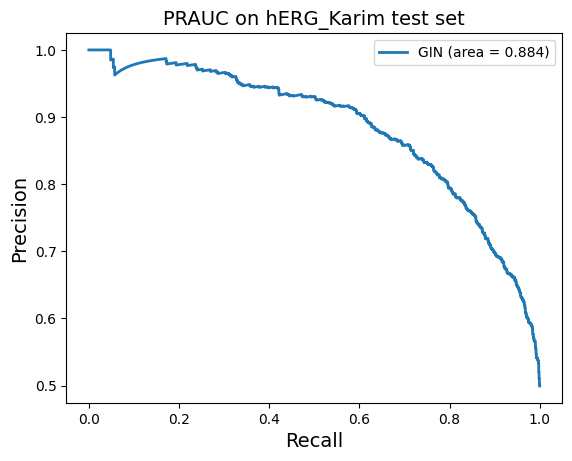


*************** AMES ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.830  &0.827  &0.835  &0.858  &0.795  &0.847 &0.893 &0.655 &0.907


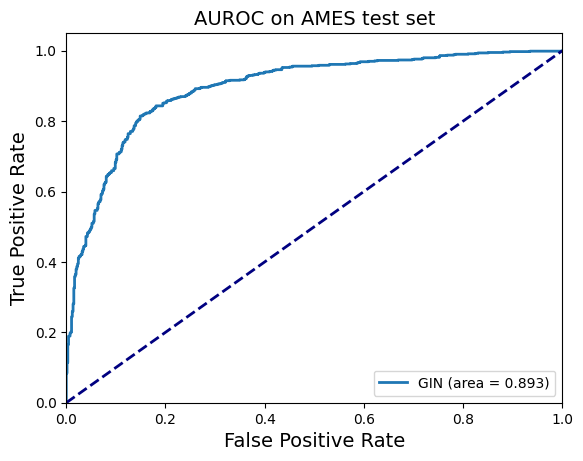

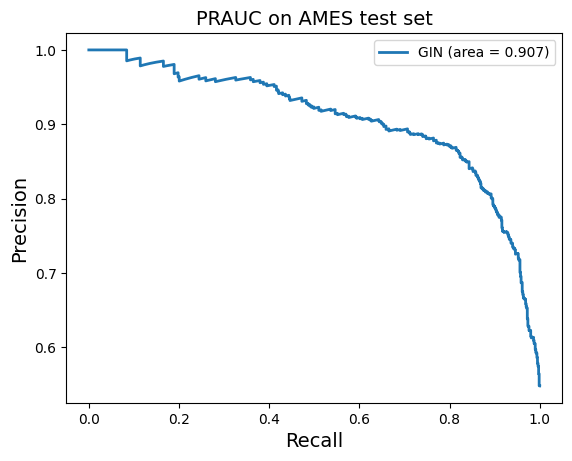

In [87]:
task_name = 'AMES'
model_type = 'GIN'
i = 2
file_name = f'T3/uw_no/{model_type}_MT_{i}.yml'
p_MT = yml_report(file_name, recalculate=True, return_all=True)


In [88]:
eval_perf_list([p_MT[0]], task_name)

******************** AMES ******************** 
	|  acc  |  auc  |  ap  
single: &0.830   &0.893   &0.907   


0

# Multitask with uncertainty weight on AMES

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


collect data for:  ['LD50_Zhu', 'hERG_Karim', 'AMES']

START scaling train valid test data set: 
---> scale LD50_Zhu | min -0.343 | max 10.207
Finished scaling process | dict_scale: {'LD50_Zhu': [-0.3429999999999999, 10.207]} 

--> preparing data loader for model type  GIN


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 73.8MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978767
finish load data status 

load pretrained model from  T3/uw/GIN_MT_2.pt
[Test] Loss: 0.171
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.432  &0.349  &0.591  &0.609


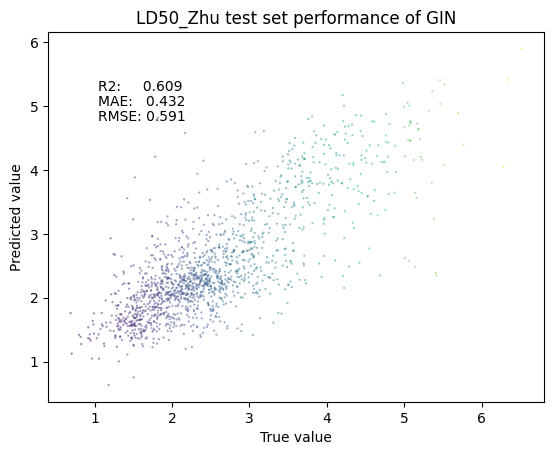


*************** hERG_Karim ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.788  &0.788  &0.790  &0.784  &0.792  &0.787 &0.869 &0.576 &0.870


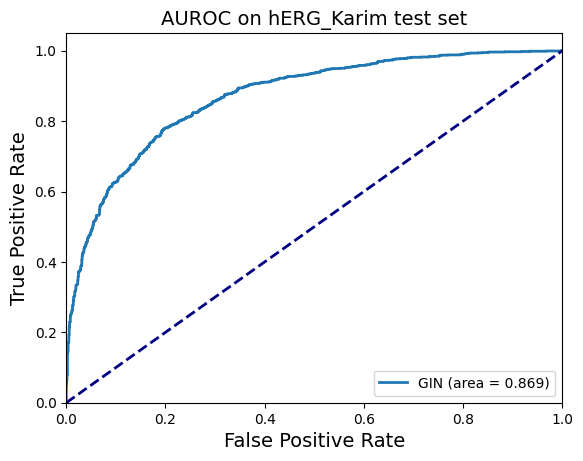

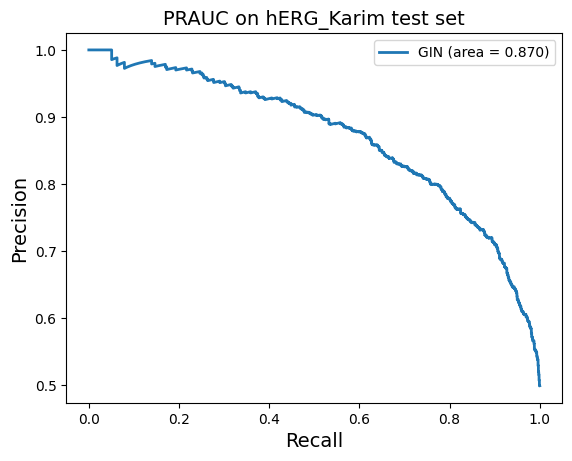


*************** AMES ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.828  &0.827  &0.848  &0.836  &0.818  &0.842 &0.896 &0.653 &0.908


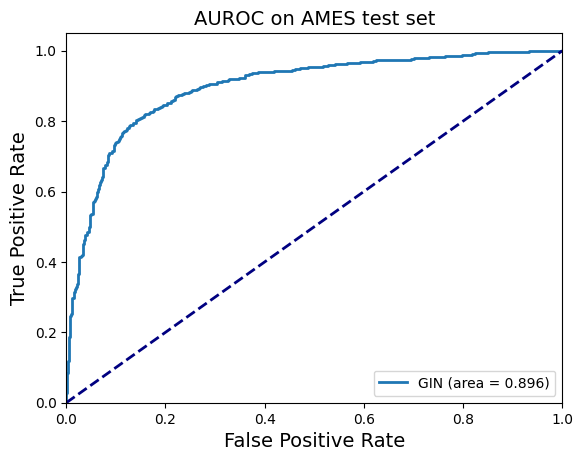

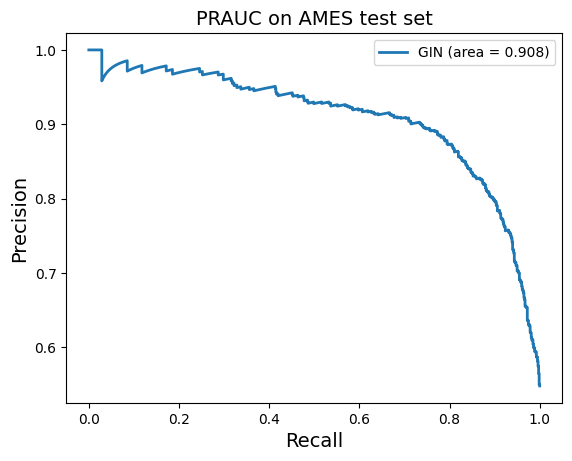

In [89]:
task_name = 'AMES'
model_type = 'GIN'
i = 2
file_name = f'T3/uw/{model_type}_MT_{i}.yml'
p_MU = yml_report(file_name, recalculate=True, return_all=True)


# MUE on AMES

In [90]:
tst_list[1]

,Drug,AMES,MLP,AttentiveFP,GIN,RNN
0,COc1nccnc1CC1=C(CCN(C)C)Cc2cc(Cl)ccc21,NaN,0.222865,0.006471,0.306590,0.058673
1,O=C(NC1CCN(Cc2ccn(-c3ccc(C(F)(F)F)cc3)c2)CC1)N...,NaN,0.230177,0.007573,0.044678,0.035468
2,Fc1ccc(Cn2cc(NCCN3CCCCC3)nn2)cc1F,NaN,0.394140,0.995754,0.222278,0.737605
3,CC1(C)C[C@@H](NC(=O)CC(O)(C(F)(F)F)C(F)(F)F)c2...,NaN,0.290576,0.084882,0.238468,0.055120
4,O=C(O)C[C@@H]1c2ccccc2C[C@H]1NC(=O)c1cc2sc(Cl)...,NaN,0.471504,0.001728,0.146850,0.059970
...,...,...,...,...,...,...
5546,CCCC1COC(Cn2cncn2)(c2ccc(Cl)cc2Cl)O1,NaN,0.263926,0.877365,0.318159,0.024637
5547,CCOP(=S)(OCC)Oc1ccc([N+](=O)[O-])c(Cl)c1,NaN,0.880387,0.916540,0.610818,0.934390
5548,Cc1ccc2c(c1)CC(=O)c1cc(CC(=O)O)ccc1O2,NaN,0.473219,0.477201,0.069328,0.014019
5549,CCS(=O)(=O)CCSP(=O)(OC)OC,NaN,0.552328,0.699520,0.540128,0.390091


In [93]:
task_name = 'AMES'
task_num = 1
i = 2
folder_name = 'T3/uw'
config_path = folder_name + '/MUE_' + task_name  + '_' +  str(i) + '.yml'

In [94]:
import yaml
with open(config_path, 'r') as f: data = yaml.safe_load(f)
config = data['config']
batch_size = config['batch_size']
params_ = {'batch_size': batch_size, 'shuffle': True,
                'drop_last': False, 'num_workers': 0}

param_t = {'batch_size': batch_size, 'shuffle': False,
                'drop_last': False, 'num_workers': 0}


trn_l = DataLoader(ensemble_dataset(trn_list[task_num], task_name), **params_)
val_l = DataLoader(ensemble_dataset(val_list[task_num], task_name), **params_)
tst_l = DataLoader(ensemble_dataset(tst_list[task_num], task_name), **param_t)

Model type:  MUE | Model parameters:  2945
finish load data status 

load pretrained model from  T3/uw/MUE_AMES_2.pt
[Test] Loss: 0.113
*************** AMES ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.832  &0.828  &0.835  &0.863  &0.793  &0.849 &0.907 &0.660 &0.923


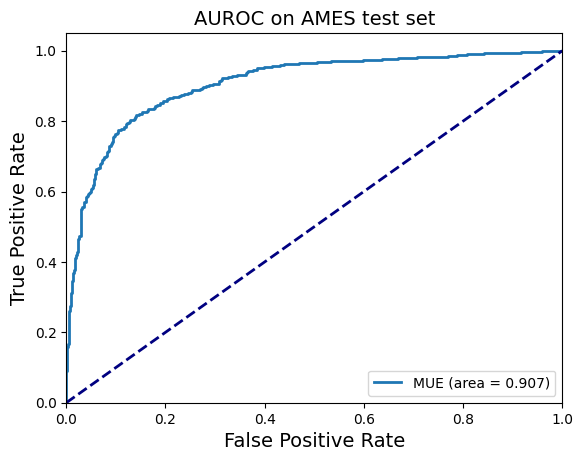

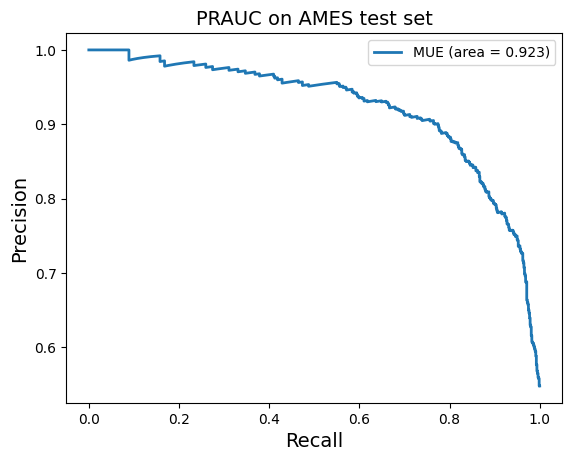

In [95]:
models = PRED(**config)
models.load_status(data)
p_MUE = models.eval(tst_l)

In [102]:
probs_list = []
label_list = []
model_list = []
model_type = 'GIN'
probs_list.append(p_ST[1][task_name]) # single task, probability
label_list.append(p_ST[2][task_name])
model_list.append(f'ST-{model_type}')

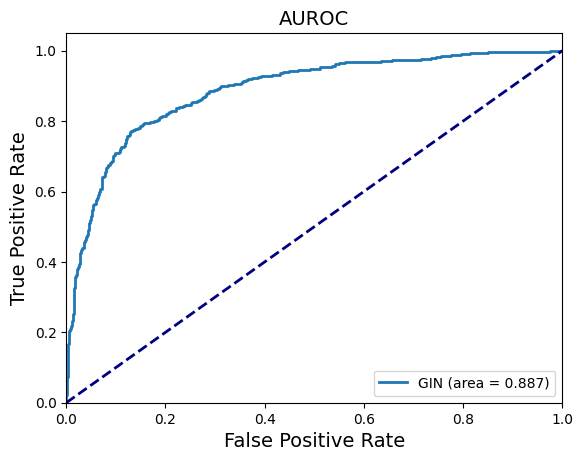

In [101]:
import numpy as np
roc_curve(np.array(p_ST[1][task_name]), np.array(p_ST[2][task_name]),
          method_name=f'{model_type}')

In [103]:
probs_list.append(p_MT[1][task_name])
label_list.append(p_MT[2][task_name])
model_list.append(f'MT-{model_type}')

In [104]:
probs_list.append(p_MU[1][task_name])
label_list.append(p_MU[2][task_name])
model_list.append(f'MU-{model_type}')

In [105]:
probs_list.append(p_MUE[1][task_name])
label_list.append(p_MUE[2][task_name])
model_list.append('MUE (Ours)')

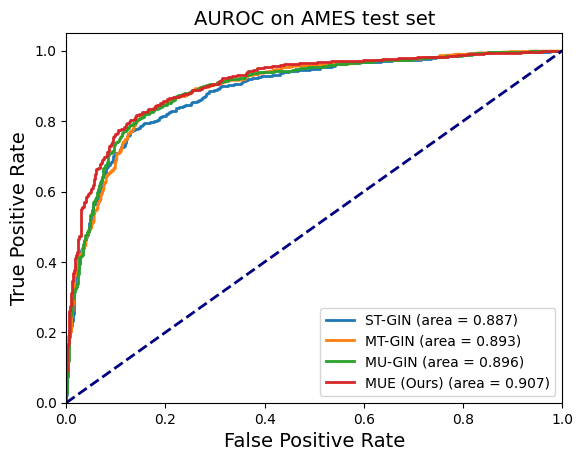

In [108]:
roc_curve_batch(probs_list, label_list, model_list, figure_title=f'{task_name}')

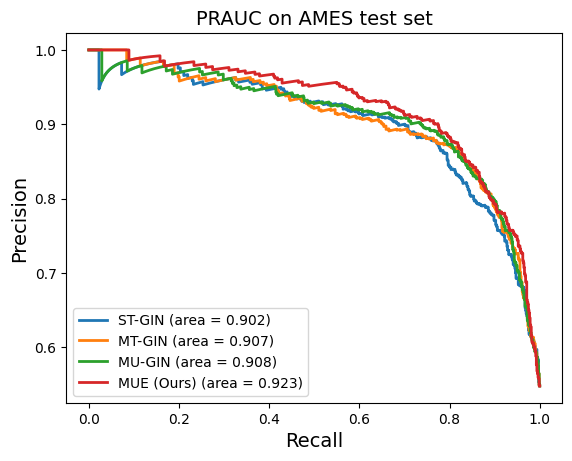

In [109]:
prc_curve_batch(probs_list, label_list, model_list, figure_title=f'{task_name}')